# EuroSAT images classification

In [2]:
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import warnings
import torch
import torch.nn as nn
import torchvision
warnings.filterwarnings('ignore')
print("NumPy version: %s"%np.__version__)
print("Pandas version: %s"%pd.__version__)
print("PyTorch version: %s"%torch.__version__)

NumPy version: 1.23.1
Pandas version: 1.4.3
PyTorch version: 1.13.0


In [3]:
import os
import pathlib

imgdir_path = pathlib.Path('../../eurosatprj/data/EuroSAT/2750/AnnualCrop')
file_path_list = [str(path) for path in imgdir_path.glob('*.jpg')]
file_list = [os.path.basename(file) for file in file_path_list]
file_list[:3]

['AnnualCrop_1.jpg', 'AnnualCrop_10.jpg', 'AnnualCrop_100.jpg']

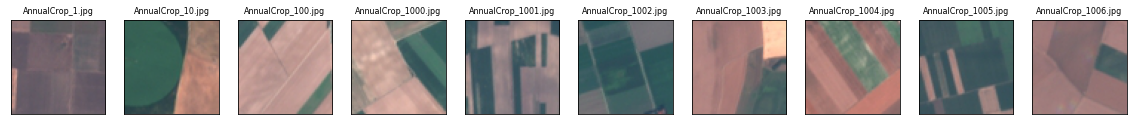

In [4]:
from itertools import islice
from PIL import Image

fig = plt.figure(figsize=(20, 10))
for i, image in islice(enumerate(file_path_list), 10):
    ax = fig.add_subplot(1, 10, i+1)
    ax.set_xticks([]); ax.set_yticks([])
    label = os.path.basename(image)
    ax.set_title(f'{label}', size=8)
    img = Image.open(image)
    ax.imshow(img)
    


In [5]:
from torch.utils.data import Dataset
from torchvision.io import read_image

class EuroSatDataset(Dataset):
    def __init__(self, img_dir, transform=None, target_transform=None):
        file_path_list = [str(path) for path in imgdir_path.glob('*.jpg')]
        labels = [os.path.basename(file) for file in file_path_list]
        self.img_labels = labels
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, index):
        image = read_image(self.img_dir[index])      
        label = self.img_labels[index]
        if self.transform:
            image = self.transform(image)
        
        return image, label

In [6]:
import torchvision.transforms as transforms 

transform = transforms.Compose([
    transforms.ToTensor(),
])

In [7]:
eurosat_dataset = EuroSatDataset(file_path_list)

In [ ]:
samples = [enum_value for i, enum_value in enumerate(eurosat_dataset) if i < 10]

In [88]:
for sample in samples:
    image, label = sample
    print(label)

AnnualCrop_1.jpg
AnnualCrop_10.jpg
AnnualCrop_100.jpg
AnnualCrop_1000.jpg
AnnualCrop_1001.jpg
AnnualCrop_1002.jpg
AnnualCrop_1003.jpg
AnnualCrop_1004.jpg
AnnualCrop_1005.jpg
AnnualCrop_1006.jpg


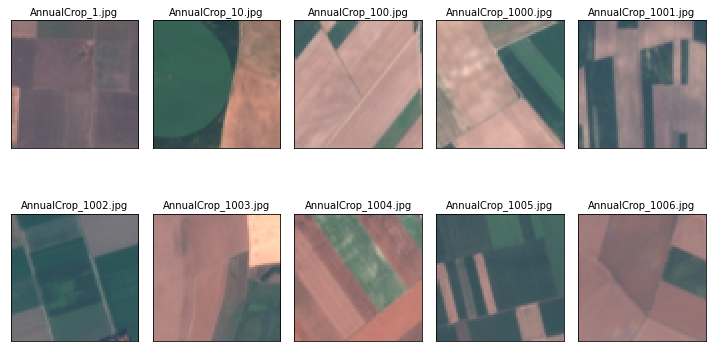

In [91]:
fig = plt.figure(figsize=(10, 6))
for i, example in enumerate(samples):
    ax = fig.add_subplot(2, 5, i+1)
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(example[0].numpy().transpose((1, 2, 0)))
    ax.set_title(f'{example[1]}', size=10)
    
plt.tight_layout()
plt.show()